## Import 

In [1]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

import PIL.ImageOps
import requests
from PIL import Image

## Download Training Dataset

In [2]:
transform  = transforms.Compose([transforms.Resize((28,28)),
                                 transforms.ToTensor()
                                ])
training_dataset = datasets.MNIST(root='./mnist', train=True, 
                                  download=True, transform= transform)
validation_dataset = datasets.MNIST(root='./mnist', train=False, 
                                  download=True, transform= transform) 

print ("length of training_dataset: ", len(training_dataset))
print ("length of validation_dataset: ", len(validation_dataset))

length of training_dataset:  60000
length of validation_dataset:  10000


## Shape of the image tensor

In [3]:
print (training_dataset[0][0].shape)

torch.Size([1, 28, 28])


## Visualize Training Samples

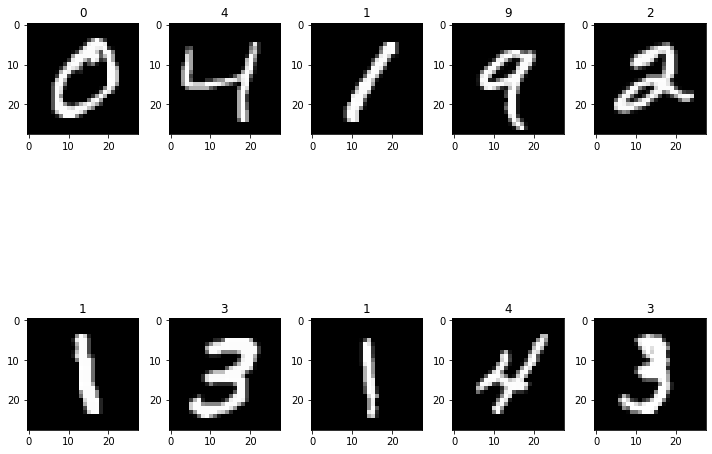

In [4]:
fig=plt.figure(figsize=(10, 10))

for idx in range(1, 11):
  fig.add_subplot(2, 5, idx)
  # title is the image's label
  plt.title(training_dataset[idx][1])
  plt.imshow(transforms.ToPILImage()(training_dataset[idx][0]), cmap='gray')
plt.tight_layout()
plt.show()

## Create our model

In [5]:
class Model(nn.Module):
    def __init__(self, input_size, h1, h2, output_size):
        super().__init__() 
        self.layer_1 = nn.Linear(input_size, h1)
        self.layer_2 = nn.Linear(h1, h2)
        self.layer_3 = nn.Linear(h2, output_size)
    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

## Define our model

In [6]:
model = Model(784, 300, 100, 10)
print (model)

Model(
  (layer_1): Linear(in_features=784, out_features=300, bias=True)
  (layer_2): Linear(in_features=300, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=10, bias=True)
)


## DataLoader

In [7]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, 
                                              batch_size=100,
                                              shuffle=True)
   
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                              batch_size=100,
                                              shuffle=True)

## Training in action

In [8]:
# Cross Entropy Loss with Adam Optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

epochs = 3

for e in range(epochs):

    train_corrects = 0.0 
    train_batch_loss = 0.0
    train_epoch_loss = 0.0
    val_corrects = 0.0
    val_epoch_loss = 0.0
    
    # loop through 60000 samples 100 at a time
    for batch_idx, data in enumerate(training_loader, start=1):
        # convert (100, 1, 28 , 28) to (100, 748)
        # data[0] is the array containing 100(batch_size) number of 1*28*28
        # data[1] is the array containing 100 number of lables
        inputs = data[0].view(data[0].shape[0], -1)
        labels = data[1]
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Return the index of the highest possibility
        # which are the predicted labels
        _, preds = torch.max(outputs, 1)
        train_batch_loss += loss.item()

        # sum up all the correct prediction
        # since (preds==labels).sum() is a tensor
        # we use item() to extract the number
        train_corrects += (preds == labels).sum().item()

        # print training loss every 100 mini-batch
        # train_batch_loss is the average loss for 100 mini-batch
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                   e + 1 , 
                   batch_idx * len(data[0]), 
                   len(training_loader.dataset),
                   100.* batch_idx * len(data[0]) / len(training_loader.dataset), 
                   train_batch_loss / 100 ))
            # accumulate loss for the epoch
            train_epoch_loss += train_batch_loss
            # reset the loss for every mini-batch
            train_batch_loss = 0.0
    else:
        # torch.no_grad deactivate the auograd engine, 
        # reduce memory usage and speed up computations
        with torch.no_grad():
            for val_data in validation_loader:
                val_inputs = val_data[0].view(val_data[0].shape[0], -1)
                val_labels = val_data[1]
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_epoch_loss += val_loss.item()
                val_corrects += (val_preds == val_labels).sum().item()


        # print result for every epoch 
        train_accuracy = 100. * train_corrects / len(training_loader.dataset)
        # here batch_idx is the total number of mini-batch = 600
        train_epoch_loss /= batch_idx

        print('epoch :', (e+1))
        print('Train set: Accuracy: {}/{} ({:.0f}%), Average Loss: {:.6f}'.format(
                train_corrects, len(training_loader.dataset),
                train_accuracy, train_epoch_loss))


        
        val_accuracy = 100. * val_corrects / len(validation_loader.dataset)
        val_epoch_loss /= batch_idx

        print('Validation set: Accuracy: {}/{} ({:.0f}%), Average Loss: {:.6f}'.format(
                val_corrects, len(validation_loader.dataset),
                val_accuracy, val_epoch_loss))

Train Epoch: 1 [10000/60000 (17%)] Loss: 0.471357
Train Epoch: 1 [20000/60000 (33%)] Loss: 0.236051
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.205086
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.183945
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.161314
Train Epoch: 1 [60000/60000 (100%)] Loss: 0.158010
epoch : 1
Train set: Accuracy: 55725.0/60000 (93%), Average Loss: 0.235960
Validation set: Accuracy: 9622.0/10000 (96%), Average Loss: 0.021299
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.123148
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.132364
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.130814
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.133568
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.115897
Train Epoch: 2 [60000/60000 (100%)] Loss: 0.125086
epoch : 2
Train set: Accuracy: 57821.0/60000 (96%), Average Loss: 0.126813
Validation set: Accuracy: 9728.0/10000 (97%), Average Loss: 0.016021
Train Epoch: 3 [10000/60000 (17%)] Loss: 0.093623
Train Epoch: 3 [20000/60000 (33%)] Loss: 0.095558
Train Epoc

## Predicted v.s Ground Truth

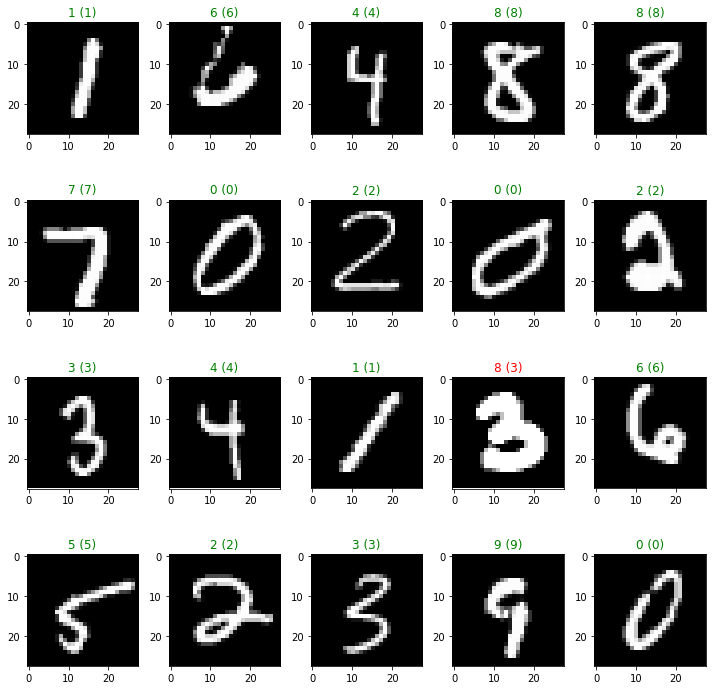

In [9]:
# Visualize predicted labels Vs. ground truth
dataiter = iter(validation_loader)

# Get the first 100 samples from validation dataset
images, labels = dataiter.next()
output = model(images.view(images.shape[0], -1))
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(10, 10))

# Print the first 20 images
for idx in range(1, 21):
    ax = fig.add_subplot(4, 5, idx)
    plt.title("{} ({})".format(str(preds[idx].item()), 
                              str(labels[idx].item())), 
                        color=("green" if preds[idx]==labels[idx] else "red"))
    plt.imshow(transforms.ToPILImage()(images[idx]), cmap='gray')
plt.tight_layout()
plt.show()

## Test on data from online

our predicted result is  1


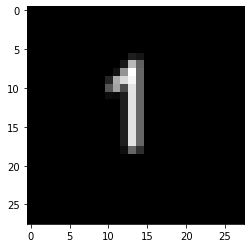

In [13]:
url = 'https://upload.wikimedia.org/wikipedia/commons/c/c5/Number-One.JPG'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

# invert the back and white part 
# so it matches with our training data
img = PIL.ImageOps.invert(img)

# convert image to grey-scaled. 
# so the color channel would be 1 
img = img.convert('L')
img = transform(img) 
plt.imshow(transforms.ToPILImage()(img), cmap='gray')


img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print("our predicted result is ", pred.item())